# Text Representation with Feature Engineering

### Exploring Word Embeddings with New Deep Learning Models

We have discussed in the previous sub-unit that Feature Engineering is the secret sauce to creating superior and better performing machine learning models. 

Traditional (count-based) feature engineering strategies for textual data involve models belonging to a family of models popularly known as the Bag of Words model. This includes term frequencies, TF-IDF (term frequency-inverse document frequency), N-grams and so on. While they are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document. 

This forms as enough motivation for us to explore more sophisticated models which can capture this information and give us features which are vector representation of words, popularly known as embeddings.

Here we will explore the following feature engineering techniques:

- Word2Vec
- GloVe
- FastText

Predictive methods like Neural Network based language models try to predict words from its neighboring words looking at word sequences in the corpus and in the process it learns distributed representations giving us dense word embeddings. We will be focusing on these predictive methods in this article.

# Prepare a Sample Corpus

Let’s now take a sample corpus of documents on which we will run most of our analyses in this article. A corpus is typically a collection of text documents usually belonging to one or more subjects or domains.

In [6]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = 200

corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


Let's go ahead and pre-process our text data now

# Simple Text Pre-processing

Since the focus of this unit is on feature engineering, we will build a simple text pre-processor which focuses on removing special characters, extra whitespaces, digits, stopwords and lower casing the text corpus.

In [7]:
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)
norm_corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peshw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peshw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

# The Word2Vec Model

This model was created by Google in 2013 and is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary. 

Usually you can specify the size of the word embedding vectors and the total number of vectors are essentially the size of the vocabulary. This makes the dimensionality of this dense vector space much lower than the high-dimensional sparse vector space built using traditional Bag of Words models.

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include,

- The Continuous Bag of Words (CBOW) Model
- The Skip-gram Model

## The Continuous Bag of Words (CBOW) Model

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). 

Considering a simple sentence, ___“the quick brown fox jumps over the lazy dog”___, this can be pairs of __(context_window, target_word)__ where if we consider a context window of size 2, we have examples like __([quick, fox], brown)__, __([the, brown], quick)__, __([the, dog], lazy)__ and so on. 

Thus the model tries to predict the __`target_word`__ based on the __`context_window`__ words.

![](https://github.com/dipanjanS/nlp_workshop_odsc19/blob/master/Module04%20-%20Text%20Representation/cbow_arch.png?raw=1)


## The Skip-gram Model

The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. It tries to predict the source context words (surrounding words) given a target word (the center word). 

Considering our simple sentence from earlier, ___“the quick brown fox jumps over the lazy dog”___. If we used the CBOW model, we get pairs of __(context_window, target_word)__ where if we consider a context window of size 2, we have examples like __([quick, fox], brown)__, __([the, brown], quick)__, __([the, dog], lazy)__ and so on. 

Now considering that the skip-gram model’s aim is to predict the context from the target word, the model typically inverts the contexts and targets, and tries to predict each context word from its target word. Hence the task becomes to predict the context __[quick, fox]__ given target word __‘brown’__ or __[the, brown]__ given target word __‘quick’__ and so on. 

Thus the model tries to predict the context_window words based on the target_word.

![](https://github.com/dipanjanS/nlp_workshop_odsc19/blob/master/Module04%20-%20Text%20Representation/skipgram_arch.png?raw=1)

# Robust Word2Vec Model with Gensim

The __`gensim`__ framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the Word2Vec model. We will leverage the same on our sample toy corpus. In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it.

- __`size`:__ The word embedding dimensionality
- __`window`:__ The context window size
- __`min_count`:__ The minimum word count
- __`sample`:__ The downsample setting for frequent words
- __`sg`:__ Training model, 1 for skip-gram otherwise CBOW

We will build a simple Word2Vec model on the corpus and visualize the embeddings.

In [8]:
import nltk
from gensim.models import word2vec

tokenized_corpus = [nltk.word_tokenize(doc) for doc in norm_corpus]

# Set values for various parameters
feature_size = 15    # Word vector dimensionality  
window_context = 20  # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3        # Downsample setting for frequent words
sg = 1               # skip-gram model

w2v_model = word2vec.Word2Vec(tokenized_corpus, 
                              window=window_context, min_count = min_word_count,
                              sg=sg, sample=sample)
w2v_model

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


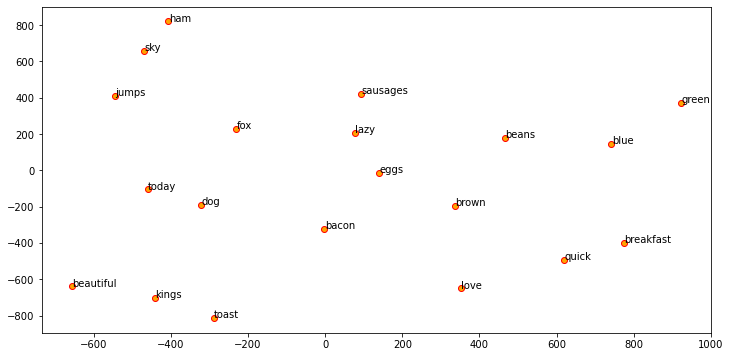

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index_to_key
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [10]:
w2v_model.wv['sky'], w2v_model.wv['sky'].shape

(array([-0.00053284,  0.0002355 ,  0.00510643,  0.00900563, -0.00930537,
        -0.00712327,  0.00645674,  0.0089788 , -0.0050154 , -0.00376946,
         0.00738573, -0.00153804, -0.00453778,  0.00655376, -0.00486056,
        -0.00181047,  0.00287806,  0.00099188, -0.00827994, -0.00944862,
         0.00731287,  0.00506933,  0.00676219,  0.00076189,  0.00634605,
        -0.00340157, -0.00094943,  0.00576983, -0.00751381, -0.0039374 ,
        -0.0075127 , -0.00093124,  0.00954387, -0.00731466, -0.00233048,
        -0.00193676,  0.00808468, -0.00593122,  0.00004186, -0.00475079,
        -0.00960139,  0.00500511, -0.00876237, -0.00438649, -0.00003868,
        -0.00029575, -0.00766406,  0.00961257,  0.00498083,  0.00923122,
        -0.00816112,  0.00449227, -0.00413935,  0.00082709,  0.00849971,
        -0.00445931,  0.00451762, -0.00678583, -0.00353982,  0.00940205,
        -0.00158375,  0.00032194, -0.00413758, -0.00768055, -0.00151129,
         0.00247213, -0.00089148,  0.00553118, -0.0

In [11]:
vec_df = pd.DataFrame(wvs, index=words)
vec_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
sky,-0.000533,0.000235,0.005106,0.009006,-0.009305,-0.007123,0.006457,0.008979,-0.005015,-0.003769,...,0.001637,0.000189,0.003472,0.000222,0.009614,0.005059,-0.008910,-0.007041,0.000901,0.006394
blue,-0.008618,0.003673,0.005192,0.005741,0.007473,-0.006173,0.001114,0.006053,-0.002838,-0.006180,...,0.001093,-0.001575,0.002202,-0.007882,-0.002711,0.002665,0.005343,-0.002390,-0.009514,0.004512
lazy,0.000100,0.003081,-0.006810,-0.001383,0.007674,0.007340,-0.003669,0.002650,-0.008329,0.006200,...,-0.004499,0.005705,0.009187,-0.004101,0.007971,0.005383,0.005884,0.000506,0.008220,-0.007033
beautiful,-0.008245,0.009298,-0.000197,-0.001961,0.004605,-0.004096,0.002745,0.006941,0.006061,-0.007511,...,-0.007427,-0.001066,-0.000795,-0.002566,0.009684,-0.000456,0.005872,-0.007450,-0.002506,-0.005550
quick,-0.007133,0.001239,-0.007173,-0.002247,0.003712,0.005829,0.001199,0.002107,-0.004113,0.007220,...,0.003142,-0.004713,0.005281,-0.004228,0.002642,-0.008046,0.006211,0.004815,0.000790,0.003012
brown,-0.008727,0.002131,-0.000872,-0.009319,-0.009427,-0.001411,0.004435,0.003705,-0.006501,-0.006875,...,0.009072,0.008939,-0.008208,-0.003013,0.009890,0.005106,-0.001589,-0.008696,0.002962,-0.006679
fox,0.008133,-0.004452,-0.001070,0.001003,-0.000184,0.001146,0.006115,-0.000016,-0.003248,-0.001512,...,-0.002699,0.000448,-0.003533,-0.000422,-0.000705,0.000826,0.008197,-0.005735,-0.001659,0.005570
dog,0.008170,-0.004445,0.008983,0.008263,-0.004437,0.000309,0.004274,-0.003926,-0.005566,-0.006509,...,0.002053,-0.004005,-0.008242,0.006279,-0.001943,-0.000667,-0.001773,-0.004537,0.004066,-0.004270
sausages,-0.009579,0.008943,0.004165,0.009235,0.006644,0.002925,0.009804,-0.004425,-0.006803,0.004227,...,-0.005085,0.001131,0.002883,-0.001536,0.009932,0.008350,0.002416,0.007118,0.005891,-0.005581
ham,-0.005155,-0.006665,-0.007776,0.008309,-0.001977,-0.006860,-0.004149,0.005151,-0.002873,-0.003756,...,-0.008972,0.008593,0.004052,0.007469,0.009752,-0.007287,-0.009038,0.005833,0.009391,0.003507


### Looking at term semantic similarity

In [12]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(vec_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
similarity_df

,sky,blue,lazy,beautiful,quick,brown,fox,dog,sausages,ham,bacon,eggs,love,breakfast,kings,green,jumps,toast,beans,today
sky,1.000000,-0.010486,-0.052628,-0.111528,-0.027551,-0.059903,0.016010,0.093210,0.027032,0.216277,0.063204,0.079641,0.093197,-0.041206,-0.037588,0.054451,0.218867,-0.113870,-0.014342,0.002472
blue,-0.010486,1.000000,-0.023673,0.068212,0.004253,0.009366,-0.113922,-0.115575,0.033609,-0.095451,-0.134269,0.008203,-0.003616,0.137272,0.161227,0.123320,0.022355,0.085752,0.159690,-0.159853
lazy,-0.052628,-0.023673,1.000000,-0.013439,0.170080,0.064290,0.146087,-0.002024,0.199144,-0.032889,-0.101577,0.173161,0.046518,-0.135233,-0.185223,-0.019798,-0.017042,0.002146,0.152968,-0.035183
beautiful,-0.111528,0.068212,-0.013439,1.000000,-0.044538,0.131579,0.041589,-0.013624,0.074971,-0.169292,0.012924,0.041348,-0.009290,0.006648,0.178155,-0.153942,-0.260758,0.041376,-0.041950,-0.001830
quick,-0.027551,0.004253,0.170080,-0.044538,1.000000,0.138832,0.034770,-0.028082,-0.069024,-0.173125,-0.258496,-0.005777,0.150277,0.252918,-0.086099,0.016038,0.108613,-0.029504,0.032947,-0.276838
brown,-0.059903,0.009366,0.064290,0.131579,0.138832,1.000000,0.019214,-0.057632,0.060613,-0.105102,0.019992,0.166978,-0.145121,0.044112,-0.109112,-0.026460,0.047645,0.071818,-0.140769,-0.126858
fox,0.016010,-0.113922,0.146087,0.041589,0.034770,0.019214,1.000000,0.004815,0.008904,0.001921,0.050417,-0.083685,0.000719,0.012811,0.007866,-0.146393,0.163691,-0.107197,0.074837,0.110690
dog,0.093210,-0.115575,-0.002024,-0.013624,-0.028082,-0.057632,0.004815,1.000000,-0.144459,-0.093106,0.108749,0.111620,-0.040845,-0.025583,0.105429,0.080558,0.174864,0.119101,0.079293,0.318992
sausages,0.027032,0.033609,0.199144,0.074971,-0.069024,0.060613,0.008904,-0.144459,1.000000,0.044722,0.026763,0.037713,-0.040441,-0.122462,-0.076904,-0.014549,-0.120705,0.012425,0.015794,0.096739
ham,0.216277,-0.095451,-0.032889,-0.169292,-0.173125,-0.105102,0.001921,-0.093106,0.044722,1.000000,0.014945,-0.074221,-0.045663,-0.106110,-0.045302,0.010598,0.006430,-0.160124,0.020276,-0.037992


In [13]:
feature_names = np.array(words)
similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:4]], 
                    axis=1)

sky                  [jumps, ham, dog]
blue         [kings, beans, breakfast]
lazy           [sausages, eggs, quick]
beautiful     [kings, brown, sausages]
quick          [breakfast, lazy, love]
brown         [eggs, quick, beautiful]
fox               [jumps, lazy, today]
dog              [today, jumps, toast]
sausages      [lazy, today, beautiful]
ham             [sky, sausages, beans]
bacon                [love, eggs, dog]
eggs              [lazy, brown, beans]
love               [quick, bacon, sky]
breakfast         [quick, beans, blue]
kings        [toast, beautiful, today]
green               [blue, dog, jumps]
jumps                  [sky, dog, fox]
toast              [kings, beans, dog]
beans          [blue, lazy, breakfast]
today                [dog, kings, fox]
dtype: object

# The GloVe Model

The GloVe model stands for Global Vectors which is an unsupervised learning model which can be used to obtain dense word vectors similar to Word2Vec. However the technique is different and training is performed on an aggregated global word-word co-occurrence matrix, giving us a vector space with meaningful sub-structures. This method was invented in Stanford by Pennington et al. and I recommend you to read the original paper on GloVe, _[‘GloVe: Global Vectors for Word Representation’ by Pennington et al.](https://nlp.stanford.edu/pubs/glove.pdf)_ which is an excellent read to get some perspective on how this model works.

The basic methodology of the GloVe model is to first create a huge word-context co-occurence matrix consisting of (word, context) pairs such that each element in this matrix represents how often a word occurs with the context (which can be a sequence of words). The idea then is to apply matrix factorization to approximate this matrix as depicted in the following figure.

![](https://github.com/dipanjanS/nlp_workshop_odsc19/blob/master/Module04%20-%20Text%20Representation/glove_arch.png?raw=1)

Considering the __Word-Context (WC)__ matrix, __Word-Feature (WF)__ matrix and __Feature-Context (FC)__ matrix, we try to factorize __WC = WF x FC__

Such that we we aim to reconstruct __WC__ from __WF__ and __FC__ by multiplying them. For this, we typically initialize __WF__ and __FC__ with some random weights and attempt to multiply them to get __WC'__ (an approximation of __WC__) and measure how close it is to __WC__. We do this multiple times using Stochastic Gradient Descent (SGD) to minimize the error. Finally, the __Word-Feature matrix (WF)__ gives us the word embeddings for each word where __F__ can be preset to a specific number of dimensions

# Robust Glove Model with SpaCy

Let’s try and leverage GloVe based embeddings for our document clustering task. The very popular spacy framework comes with capabilities to leverage GloVe embeddings based on different language models. You can also get pre-trained word vectors and load them up as needed using gensim or spacy.

If you have spacy installed, we will be using the __[`en_vectors_web_lg`](https://spacy.io/models/en#en_vectors_web_lg)__ model which consists of 300-dimensional word vectors trained on [Common Crawl](http://commoncrawl.org) with GloVe.

__Install Instructions:__

```
# Use the following command to install spaCy
> pip install -U spacy
OR
> conda install -c conda-forge spacy

C:\WINDOWS\system32>python -m spacy download en_vectors_web_lg
Collecting en_vectors_web_lg==2.0.0 from https://github.com/explosion/spacy-models/releases/download/en_vectors_web_lg-2.0.0/en_vectors_web_lg-2.0.0.tar.gz#egg=en_vectors_web_lg==2.0.0
  Downloading https://github.com/explosion/spacy-models/releases/download/en_vectors_web_lg-2.0.0/en_vectors_web_lg-2.0.0.tar.gz (661.8MB)
    100% |████████████████████████████████| 661.8MB 392kB/s
Installing collected packages: en-vectors-web-lg
  Running setup.py install for en-vectors-web-lg ... done
Successfully installed en-vectors-web-lg-2.0.0
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.

    Linking successful
    C:\Anaconda3\lib\site-packages\en_vectors_web_lg -->
    C:\Anaconda3\lib\site-packages\spacy\data\en_vectors_web_lg

    You can now load the model via spacy.load('en_vectors_web_lg')
```

In [14]:
!python -m spacy download en

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
!python -m spacy download en_vectors_web_lg


[x] No compatible package found for 'en_vectors_web_lg' (spaCy v3.3.1)



In [17]:
import spacy

nlp = spacy.load('en_core_web_lg')
total_vectors = len(nlp.vocab.vectors)

print('Total word vectors:', total_vectors)

Total word vectors: 342918


This validates that everything is working and in order. Let’s get the GloVe embeddings for each of our words now in our toy corpus.

In [18]:
unique_words = list(set([word for sublist in tokenized_corpus for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
vec_df = pd.DataFrame(word_glove_vectors, index=unique_words)
vec_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
today,-0.156570,0.594890,-0.031445,-0.077586,0.278630,-0.509210,-0.066350,-0.081890,-0.047986,2.80360,...,-0.326580,-0.413380,0.367910,-0.262630,-0.203690,-0.296560,-0.014873,-0.250060,-0.115940,0.083741
eggs,-0.417810,-0.035192,-0.126150,-0.215930,-0.669740,0.513250,-0.797090,-0.068611,0.634660,1.25630,...,-0.232860,-0.139740,-0.681080,-0.370920,-0.545510,0.073728,0.111620,-0.324700,0.059721,0.159160
jumps,-0.334840,0.215990,-0.350440,-0.260020,0.411070,0.154010,-0.386110,0.206380,0.386700,1.46050,...,-0.107030,-0.279480,-0.186200,-0.543140,-0.479980,-0.284680,0.036022,0.190290,0.692290,-0.071501
brown,-0.374120,-0.076264,0.109260,0.186620,0.029943,0.182700,-0.631980,0.133060,-0.128980,0.60343,...,-0.015404,0.392890,-0.034826,-0.720300,-0.365320,0.740510,0.108390,-0.365760,-0.288190,0.114630
quick,-0.445630,0.191510,-0.249210,0.465900,0.161950,0.212780,-0.046480,0.021170,0.417660,1.68690,...,-0.329460,0.421860,-0.039543,0.150180,0.338220,0.049554,0.149420,-0.038789,-0.019069,0.348650
beautiful,0.171200,0.534390,-0.348540,-0.097234,0.101800,-0.170860,0.295650,-0.041816,-0.516550,2.11720,...,-0.285540,0.104670,0.126310,0.120040,0.254380,0.247400,0.207670,0.172580,0.063875,0.350990
lazy,-0.353320,-0.299710,-0.176230,-0.321940,-0.385640,0.586110,0.411160,-0.418680,0.073093,1.48650,...,0.402310,-0.038554,-0.288670,-0.244130,0.460990,0.514170,0.136260,0.344190,-0.845300,-0.077383
blue,0.129450,0.036518,0.032298,-0.060034,0.399840,-0.103020,-0.507880,0.076630,-0.422920,0.81573,...,-0.501280,0.169010,0.548250,-0.319380,-0.072887,0.382950,0.237410,0.052289,0.182060,0.412640
toast,0.130740,-0.193730,0.253270,0.090102,-0.272580,-0.030571,0.096945,-0.115060,0.484000,0.84838,...,0.142080,0.481910,0.045167,0.057151,-0.149520,-0.495130,-0.086677,-0.569040,-0.359290,0.097443
sausages,-0.174290,-0.064869,-0.046976,0.287420,-0.128150,0.647630,0.056315,-0.240440,-0.025094,0.50222,...,0.302240,0.195470,-0.653980,-0.291150,-0.684290,-0.266370,0.304310,-0.806830,0.619540,0.201200


We can now use t-SNE to visualize these embeddings similar to what we did using our Word2Vec embeddings.

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


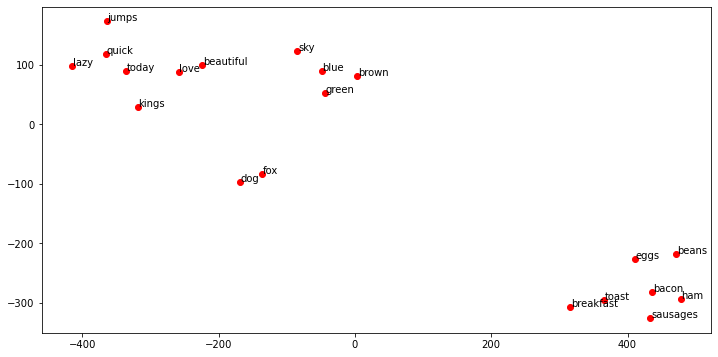

In [19]:
tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='red', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### Looking at term semantic similarity

In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(vec_df.values)
similarity_df = pd.DataFrame(similarity_matrix, index=unique_words, columns=unique_words)
similarity_df

,today,eggs,jumps,brown,quick,beautiful,lazy,blue,toast,sausages,green,beans,bacon,love,breakfast,kings,sky,fox,dog,ham
today,1.000000,0.183048,0.142099,0.147418,0.370023,0.314184,0.286803,0.180088,0.174257,0.094879,0.246754,0.147652,0.158949,0.371650,0.288788,0.204743,0.256770,0.150072,0.223730,0.104115
eggs,0.183048,1.000000,0.150621,0.466903,0.245487,0.214437,0.236769,0.297546,0.495935,0.548311,0.392072,0.585054,0.620538,0.254177,0.431108,0.118819,0.223585,0.247314,0.291202,0.489116
jumps,0.142099,0.150621,1.000000,0.110400,0.301096,0.142554,0.222112,0.187263,0.119099,0.083306,0.150752,0.095544,0.091021,0.185114,0.103865,0.086659,0.278595,0.250834,0.307961,0.046432
brown,0.147418,0.466903,0.110400,1.000000,0.217009,0.355700,0.256875,0.683011,0.347578,0.289625,0.646850,0.453427,0.432891,0.331943,0.277158,0.193487,0.408844,0.406912,0.341204,0.335111
quick,0.370023,0.245487,0.301096,0.217009,1.000000,0.289178,0.400060,0.220331,0.292624,0.162966,0.287504,0.251534,0.265370,0.292446,0.358221,0.127679,0.192515,0.192686,0.299892,0.191665
beautiful,0.314184,0.214437,0.142554,0.355700,0.289178,1.000000,0.294308,0.461366,0.189482,0.114540,0.392392,0.165268,0.151157,0.594739,0.314472,0.158615,0.428081,0.210050,0.280659,0.110936
lazy,0.286803,0.236769,0.222112,0.256875,0.400060,0.294308,1.000000,0.230513,0.231329,0.168205,0.230945,0.245672,0.264376,0.339281,0.319941,0.190515,0.259361,0.267240,0.301678,0.222571
blue,0.180088,0.297546,0.187263,0.683011,0.220331,0.461366,0.230513,1.000000,0.232264,0.097443,0.764083,0.261304,0.242987,0.364961,0.197103,0.207656,0.627800,0.371178,0.314065,0.185452
toast,0.174257,0.495935,0.119099,0.347578,0.292624,0.189482,0.231329,0.232264,1.000000,0.498062,0.287608,0.449284,0.622701,0.274246,0.513436,0.125741,0.216372,0.163371,0.182994,0.500586
sausages,0.094879,0.548311,0.083306,0.289625,0.162966,0.114540,0.168205,0.097443,0.498062,1.000000,0.233169,0.546647,0.729162,0.146917,0.415231,0.070071,0.061753,0.133348,0.247529,0.622770


In [21]:
feature_names = np.array(unique_words)
similarity_df.apply(lambda row: feature_names[np.argsort(-row.values)[1:4]], 
                    axis=1)

today        [love, quick, beautiful]
eggs         [bacon, beans, sausages]
jumps               [dog, quick, sky]
brown             [blue, green, eggs]
quick        [lazy, today, breakfast]
beautiful           [love, blue, sky]
lazy         [quick, love, breakfast]
blue              [green, brown, sky]
toast         [bacon, breakfast, ham]
sausages           [bacon, ham, eggs]
green              [blue, brown, sky]
beans         [bacon, eggs, sausages]
bacon          [ham, sausages, toast]
love         [beautiful, today, blue]
breakfast        [toast, bacon, eggs]
kings                [love, sky, fox]
sky          [blue, green, beautiful]
fox                [dog, brown, blue]
dog                [fox, love, brown]
ham          [bacon, sausages, toast]
dtype: object

# The FastText Model

The FastText model was first introduced by Facebook in 2016 as an extension and supposedly improvement of the vanilla Word2Vec model. Based on the original paper titled _[‘Enriching Word Vectors with Subword Information’](https://arxiv.org/pdf/1607.04606.pdf)_ by Mikolov et al. which is an excellent read to gain an in-depth understanding of how this model works. Overall, FastText is a framework for learning word representations and also performing robust, fast and accurate text classification. The framework is open-sourced by Facebook on [GitHub](https://github.com/facebookresearch/fastText) and claims to have the following.

- Recent state-of-the-art English word vectors.
- Word vectors for 157 languages trained on Wikipedia and Crawl.
- Models for language identification and various supervised tasks.

Though I haven't implemented this model from scratch, based on the research paper, following is what I learnt about how the model works. In general, predictive models like the Word2Vec model typically considers each word as a distinct entity (e.g. where) and generates a dense embedding for the word. However this poses to be a serious limitation with languages having massive vocabularies and many rare words which may not occur a lot in different corpora. 

The Word2Vec model typically ignores the morphological structure of each word and considers a word as a single entity. The FastText model ___considers each word as a Bag of Character n-grams___. This is also called as a ___subword model___ in the paper.

We add special boundary symbols __<__ and __>__ at the beginning and end of words. This enables us to distinguish prefixes and suffixes from other character sequences. We also include the word __w__ itself in the set of its n-grams, to learn a representation for each word (in addition to its character n-grams). 

Taking the word where and __n=3 (tri-grams)__ as an example, it will be represented by the __character n-grams__: __<wh, whe, her, ere, re>__ and the special sequence __< where >__ representing the whole word. Note that the sequence , corresponding to the word __< her >__ is different from the tri-gram __her__ from the word __where__.

In practice, the paper recommends in extracting all the n-grams for __n ≥ 3__ and __n ≤ 6__. This is a very simple approach, and different sets of n-grams could be considered, for example taking all prefixes and suffixes. We typically associate a vector representation (embedding) to each n-gram for a word. 

Thus, we can represent a word by the sum of the vector representations of its n-grams or the average of the embedding of these n-grams. Thus, due to this effect of leveraging n-grams from individual words based on their characters, there is a higher chance for rare words to get a good representation since their character based n-grams should occur across other words of the corpus.

# Robust FastText Model with Gensim

The __`gensim`__ package has nice wrappers providing us interfaces to leverage the FastText model available under the `gensim.models.fasttext` module. Let’s apply this once again on our toy corpus.

In [23]:
from gensim.models.fasttext import FastText

# Set values for various parameters
feature_size = 15    # Word vector dimensionality  
window_context = 20  # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3        # Downsample setting for frequent words
sg = 1               # skip-gram model

ft_model = FastText(tokenized_corpus, 
                     window=window_context, min_count = min_word_count,
                     sg=sg, sample=sample)
ft_model

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


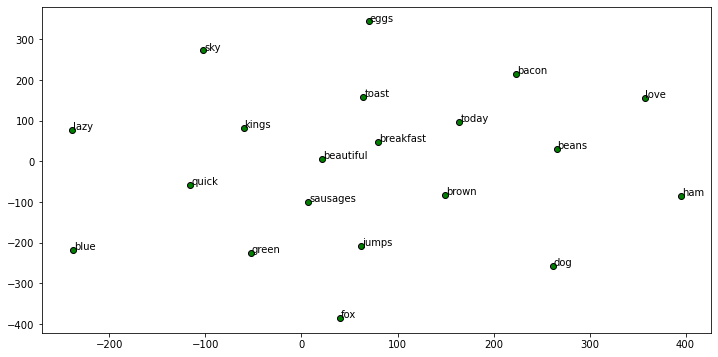

In [24]:
# visualize embeddings
from sklearn.manifold import TSNE

words = ft_model.wv.index_to_key
wvs = ft_model.wv[words]

tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='green', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

## Embedding Operations

In [25]:
ft_model.wv['sky'], ft_model.wv['sky'].shape

(array([ 0.00221835, -0.00319054,  0.00277566,  0.00102296, -0.00153656,
        -0.00163024, -0.00231491,  0.00240707, -0.00048566,  0.00098691,
        -0.00085169,  0.00126206, -0.00265305,  0.00327311,  0.00120383,
        -0.00019749,  0.00075437,  0.00002203, -0.0023516 ,  0.00075234,
         0.00159587, -0.0020277 , -0.00128701, -0.0006478 ,  0.00230742,
        -0.00089073,  0.00187692, -0.00030547,  0.00170599,  0.00128906,
        -0.00051703, -0.00038594,  0.00242666,  0.00100433, -0.00119173,
         0.00170316,  0.00242299, -0.00012247, -0.00204472,  0.00158365,
        -0.00056463,  0.00147082,  0.00026043, -0.00049712,  0.00064704,
        -0.00022024, -0.00114704,  0.00118757,  0.000212  , -0.00046281,
         0.00192766,  0.00272246, -0.0024699 , -0.00020753,  0.00364099,
        -0.00227419,  0.00199629, -0.00278769,  0.00419264,  0.00065458,
         0.00161865, -0.00176483, -0.0050681 ,  0.0039457 ,  0.00419691,
        -0.00438108,  0.00179408, -0.00103201, -0.0

In [26]:
print(ft_model.wv.similarity(w1='ham', w2='sky'))
print(ft_model.wv.similarity(w1='ham', w2='sausages'))

-0.06948187
0.034941223


In [27]:
st1 = "dog fox ham"
print('Odd one out for [',st1, ']:',  
      ft_model.wv.doesnt_match(st1.split()))

st2 = "bacon ham sky sausages"
print('Odd one out for [',st2, ']:', 
      ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ dog fox ham ]: ham
Odd one out for [ bacon ham sky sausages ]: ham


### Getting document level embeddings

Now suppose we wanted to cluster the eight documents from our toy corpus, we would need to get the document level embeddings from each of the words present in each document. One strategy would be to average out the word embeddings for each word in a document. This is an extremely useful strategy and you can adopt the same for your own problems. Let’s apply this now on our corpus to get features for each document.

In [28]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [29]:
# get document level embeddings
ft_doc_features = averaged_word_vectorizer(corpus=tokenized_corpus, model=ft_model,
                                             num_features=feature_size)
pd.DataFrame(ft_doc_features)

ValueError: operands could not be broadcast together with shapes (15,) (100,) 

### Trying out document clustering

Now that we have our features for each document, let’s cluster these documents using the Affinity Propagation algorithm, which is a clustering algorithm based on the concept of “message passing” between data points and does not need the number of clusters as an explicit input which is often required by partition-based clustering algorithms.

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(ft_doc_features)

cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, 
                              columns=['ClusterLabel'])

pd.concat([corpus_df, cluster_labels], axis=1)

We can see that our algorithm has clustered each document into the right group based on our Word2Vec features. Pretty neat! We can also visualize how each document in positioned in each cluster by using [_Principal Component Analysis (PCA)_](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the feature dimensions to 2-D and then visualizing the same (by color coding each cluster).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(ft_doc_features)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-2, y+1e-2), xytext=(0, 0), 
                 textcoords='offset points')

Everything looks to be in order as documents in each cluster are closer to each other and far apart from other clusters.